# Necessary imports
Here I use my real GPS data recorded outside for the use with
Kalman Filter.

In [ ]:
/ Read the data from the GPS dataset
t:("FFFFFFF";enlist",") 0: `:data.csv

In [8]:
t

time     ax      ay      az      Latitude Longitude Speed (m/s)
---------------------------------------------------------------
0.098634 0       0       0       0        0         0          
0.160725 0       0       0       55.75024 48.74351  1.27       
0.161885 0       0       0       55.75024 48.74351  1.27       
0.224515 0       0       0       55.75024 48.74351  1.27       
0.225168 0       0       0       55.75024 48.74351  1.27       
0.286679 0       0       0       55.75024 48.74351  1.27       
0.287367 0       0       0       55.75024 48.74351  1.27       
0.349652 0       0       0       55.75024 48.74351  1.27       
0.350454 0       0       0       55.75024 48.74351  1.27       
0.41286  0       0       0       55.75024 48.74351  1.27       
0.413996 0       0       0       55.75024 48.74351  1.27       
0.475389 0       0       0       55.75024 48.74351  1.27       
0.479517 0       0       0       55.75024 48.74351  1.27       
0.537154 0       0       0       55.7502

In [35]:
/ Map matplotlib.pyplot into q
/ It is needed for visualisations of the data
/ The code is from the examples directory
/ of the pyq library, I believe

\d .matplotlib
isroutine:.p.import[`inspect;`:isroutine];
getmembers:.p.qcallable .p.import[`inspect;`:getmembers];
wrapm:{[x]
 names:getmembers[x;isroutine];
 res:``_pyobj!((::);x);
 res,:(`$names[;0])!{.p.pycallable y 1}[x]each names;
 res}
pyplot:{wrapm .p.import`matplotlib.pyplot}

\d .

# Preprocess dataset
Here I am going to preprocess the data.

1. Calculate distance
2. Convert degrees to rads
3. Calculate acceleration

In [23]:
/ Read necessary columns from the dataset
/ QUESTION: What is a conventional way to
/ extract a data column from the table?
/ - First variant with simple extraction
/ - Second varian is select function
ts:1_t[;`time]
ax:1_t[;`ax]
ay:1_t[;`ay]
az:1_t[;`az]
/ Total amplitude of acceleraion vector
/ is sqrt of sum of squares of acccelerations
/ at each unit direction
acc:sqrt (ax * ax) + (ay * ay) + (az * az)
lat_deg:1_?[t;();();`Latitude]
lon_deg:1_?[t;();();`Longitude]

In [26]:
/ Convert degrees to r
to_rad:{[deg] acos[-1]*deg%180.0}

In [28]:
/ Convert longitude and latitude
/ to coordinates in meters
to_meters:{[lon; lat] R:6371000; (x:R*lon*cos[lat]; y:R*lat)}

In [29]:
lat_rad:to_rad lat_deg
lon_rad:to_rad lon_deg

In [31]:
/ QUESTION: How to extract return value
/ into multiple variables directly without
/ the need to split it in the next cell?
xy:to_meters[lon_rad; lat_rad]

In [33]:
x:@[xy; 0]
y:@[xy; 1]

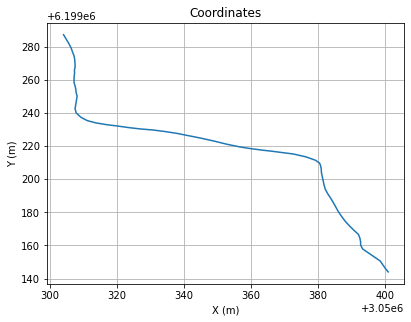

In [37]:
plt:.matplotlib.pyplot[]
plt.plot[x; y];
plt.xlabel"X (m)";
plt.ylabel"Y (m)";
plt.title"Coordinates";
plt.grid 1b;
plt.show[];

# Implementing Kalman Filter

In [287]:
dt: ts[1] - ts[0]

A: ((1; dt; dt * dt % 2; 0; 0; 0);
    (0; 1; dt; 0; 0; 0);
    (0; 0; 1; 0; 0; 0);
    (0; 0; 0; 1; dt; dt * dt % 2);
    (0; 0; 0; 0; 1; dt);
    (0; 0; 0; 0; 0; 1));

Q1: (((dt * dt * dt) % 6); ((dt * dt) % 2); (dt); (0); (0); (0));
Q2: (0; 0; 0; (dt * dt * dt) % 6; (dt * dt) % 2; dt);

xj: ((1_ax) - (-1_ax)) % ((1_ts) - (-1_ts));
yj: ((1_ay) - (-1_ay)) % ((1_ts) - (-1_ts));
j_var: max (var xj; var yj);

/Q: j_var * (Q1 * ((1; 6)#Q1) + Q2 * ((1; 6)#Q2));
/Q

In [303]:
/ Gives a rank error
/ rank error means that
/ I have provided invalid
/ number of parameters to
/ the function, but I believe
/ I have provided a single
/ vector to make a transposition.

/ Vector is somehow interpreted
/ Differently from the matrix
/ And I am not sure how to 
/ Unify this behaviour
flip Q1

[0;31mrank[0m: [0;31mrank[0m

In [303]:
/ Gives an error - why?
/ Error is "type" which means
/ that the type of a given
/ parameter is invalid
/ But I don't feel like
/ It is true. If yes, then
/ How do I define matrices?
A mmu flip A

[0;31mtype[0m: [0;31mtype[0m

In [290]:
A

1 0.00116 6.728e-07 0 0       0        
0 1       0.00116   0 0       0        
0 0       1         0 0       0        
0 0       0         1 0.00116 6.728e-07
0 0       0         0 1       0.00116  
0 0       0         0 0       1        


In [199]:
/ Writing recursive Kalman filter to
/ avoid using loops. I have to store
/ all results as one continuous 
/ vector and extract results as
/ -6#comp_res; I am not sure how
/ to append a list to a list of lists,
/ and it is a workaround I use for now
kalman_filter:{[z; A; Q; H; R; i; P; K]
    res: (z[0; 0]; 0; 0; z[0; 1]; 0; 0);
    if[i > 0; 
        comp_res: .z.s[z; A; Q; H; R; i - 1; P; K];
        prev_res: -6#comp_res;
        show comp_res;
        show prev_res;
        res:comp_res,(i; i; i; i; i; i)];
    res}

In [200]:
res: kalman_filter[((0; 0); (0; 0)); 0; 0; 0; 0; 3; 0; 0]

0 0 0 0 0 0
0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 1 1
1 1 1 1 1 1
0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2
2 2 2 2 2 2
